# MovieLens Exploratory Analysis

This notebook presents a first-pass exploratory analysis of the [MovieLens 20M data](https://grouplens.org/datasets/movielens/20m/).  The goal of the analysis is to get a sense of the contents and distribution of this data file.

## Data Source and Context

This data comes from the [MovieLens movie recommendation service](http://movielens.org).  The history of this service, artifacts of which may be present in the data, is documented in detail in the following paper:

> F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. *ACM Transactions on Interactive Intelligent Systems (TiiS)* 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872

MovieLens is a service that allows people to provide ratings (on a 5-start scale with half-star increments) for movies, browse a movie database, and receive recommendations for movies they may wish to watch.  It has operated since the late 1990s, and has a userbase primarily consisting of movie fans who are interested in a 3rd-party recommendation service and supporting science on recommender systems and online communities.

Because of the user base, and because this is rating data, we expect at least the following biases to hinder the ability to generalize from this data to the broader movie-watching public:

1. Users want to invest time in using a 3rd-party movie recommendation service where they cannot directly watch movies.  This selects for certain kinds of movie users.
2. Users are unlikely to watch & rate movies they expect not to like.  This means that, for a given movie, the ratings come from users disproportionately likely to like the movie, as opposed to what we would get if we had ratings from uniformly-sampled people.

## Setup

Import the common Python data science modules:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load Data

We are primarily concerned with the movies and their ratings, so we will load those from the appropriate CSV files.

The `movies.csv` file contains movie titles and genres:

In [2]:
movies = pd.read_csv('ml-20m/movies.csv')
movies.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
movieId    27278 non-null int64
title      27278 non-null object
genres     27278 non-null object
dtypes: int64(1), object(2)
memory usage: 4.3 MB


What do the the first few movies actually look like?

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


The `title` field is the movie title and year; the `genres` field looks like a list of genres, as a string with genres separated by a '|'.

We will go ahead and index this table by `movieId` to facilitate future lookups.

In [4]:
movies.set_index('movieId', inplace=True)
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


We will now load the ratings file:

In [5]:
ratings = pd.read_csv('ml-20m/ratings.csv')
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 610.4 MB


And look at its first few rows:

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


We will not index the rating table - that operation is less useful than it sounds.

## Data Types and Sizes

Now that the data is loaded, we want to know how much data we have: how many of each kind of object, and how many records do we have about them?

This data set contains the following key objects:

- Users
- Movies (in recommender systems language, these are often called *items*)
- Ratings

The data set also contains tags and a data structure called the 'Tag Genome', but we are not going to use those for now.

How many *movies* do we have?'

In [7]:
len(movies)

27278

How many *ratings* do we have?

In [8]:
len(ratings)

20000263

How many *users* do we have?  Users do not have a standalone table, so we need to count the number of unique users who appear in the `ratings` table.

In [9]:
ratings['userId'].nunique()

138493

Finally, how many movies actually have ratings?  This is represented by the number of unique movie IDs in the `ratings` table.

In [10]:
ratings['movieId'].nunique()

26744

## Rating Statistics

Before we look at users and items, let's get some basic statistics of use of the rating scale.  How are rating values distributed?

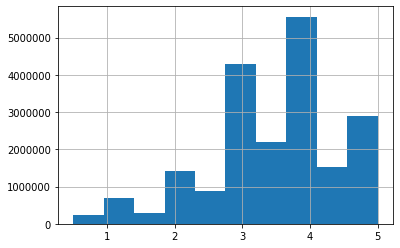

In [11]:
ratings['rating'].hist()

The continuous-data-based histogram is not necessarily a good way to display the data.  Also, we are missing axes on this plot.

Seaborn provides `countplot`, which shows the number of entries for each distinct value of a categorical variable.  Remember that ratings are really an ordered categorical variable!

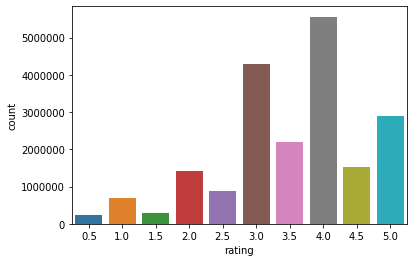

In [12]:
sns.countplot(ratings['rating'])

Now, we will describe the distribution of ratings numerically.

In [13]:
ratings['rating'].describe()

count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [14]:
ratings['rating'].mode()

0    4.0
dtype: float64

In [15]:
ratings['rating'].mean()

3.5255285642993797

In [16]:
ratings['rating'].median()

3.5

## Item Statistics

We want to look at popularity & average rating for items, so compute those:

In [17]:
item_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
item_stats.head()

,count,mean
movieId,,
1,49695,3.921240
2,22243,3.211977
3,12735,3.151040
4,2756,2.861393
5,12161,3.064592


How is popularity distributed? Let's do the naive thing:

Text(0.5, 0, '# of Ratings')

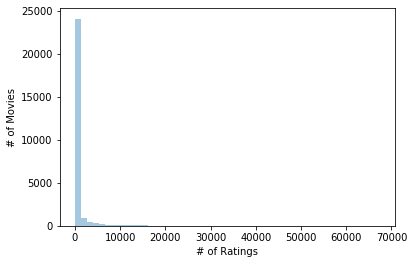

In [18]:
sns.distplot(item_stats['count'], kde=False)
plt.ylabel('# of Movies')
plt.xlabel('# of Ratings')

Strong skews have a variety of solutions.  What we will do:

1. Count movies by rating count
2. Plot on a log-log scale

In [19]:
item_pops = item_stats.groupby('count')['count'].count()
item_pops.head()

count
1    3972
2    2043
3    1355
4    1029
5     826
Name: count, dtype: int64

Text(0, 0.5, '# of Movies')

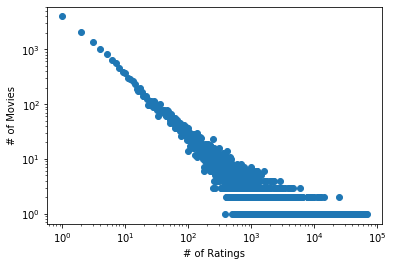

In [20]:
plt.scatter(item_pops.index, item_pops.values)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('# of Ratings')
plt.ylabel('# of Movies')

Another, perhaps more common way to view this distribution is through a *rank-size plot*.  This plots the 'size' of the object (in this case, the number of ratings for a movie) against that movie's rank, by size.  Because we have many movies with the same number of ratings, we will only plot unique ranks.

The first step is to compute the rank, in descending order so 1 is the most popular movie:

In [21]:
item_stats['rank'] = item_stats['count'].rank(ascending=False)
item_stats.head()

,count,mean,rank
movieId,,,
1,49695,3.921240,11.0
2,22243,3.211977,126.0
3,12735,3.151040,329.0
4,2756,2.861393,1647.0
5,12161,3.064592,360.0


Next, we will plot the count by the rank, over a data set in which we have dropped duplicate counts (and therefore ranks).  The Seaborn plotting functions know how to extract columns from a data frame:

Text(0.5, 0, 'Movie Popularity Rank')

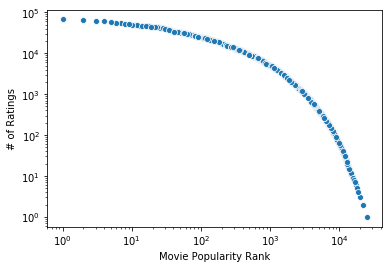

In [22]:
sns.scatterplot('rank', 'count', data=item_stats.drop_duplicates('count'))
plt.yscale('log')
plt.ylabel('# of Ratings')
plt.xscale('log')
plt.xlabel('Movie Popularity Rank')

We also want to look at this distribution numerically. We'll start with `describe` again:

In [23]:
item_stats['count'].describe()

count    26744.000000
mean       747.841123
std       3085.818268
min          1.000000
25%          3.000000
50%         18.000000
75%        205.000000
max      67310.000000
Name: count, dtype: float64

We see that the mean (747.8) is much higher even than the 75% point (18). This is because the distribution is highly skewed - the small number of very large values substantially increase the arithmetic mean.

Let's visually see how the mean and median relate in our distribution:

Text(0, 0.5, '# of Movies')

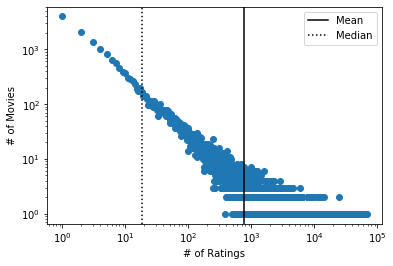

In [24]:
# base scatterplot
plt.scatter(item_pops.index, item_pops.values)

# add mean count
plt.axvline(item_stats['count'].mean(), color='black', linestyle = '-', label='Mean')
plt.axvline(item_stats['count'].median(), color='black', linestyle = ':', label='Median')

plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.xlabel('# of Ratings')
plt.ylabel('# of Movies')

Out of curiousity, what is the percentile of the mean? That is, how many movies have less than the mean number of ratings?

We can compute this by finding out whether each movie is under the mean, and taking the mean of this series.  The mean of a logical series is the fraction of the values that are true.

In [25]:
(item_stats['count'] < item_stats['count'].mean()).mean()

0.8618007777445408

86.2% of movies have less than the mean number of ratings.  That is a lot.

We haven't yet looked at average rating.  How is movie average rating distributed?

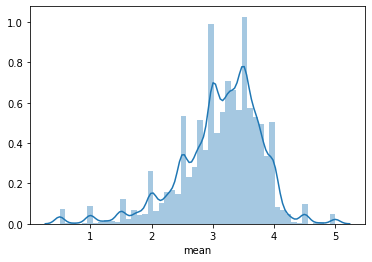

In [26]:
sns.distplot(item_stats['mean'])

> **Question to Ponder:** why are there spikes at exact rating values, like 3, 3.5, and 4?

### Movie Popularity

What are the most frequently-rated movies?

In [27]:
item_stats.nlargest(10, 'count').join(movies['title'])

,count,mean,rank,title
movieId,,,,
296,67310,4.174231,1.0,Pulp Fiction (1994)
356,66172,4.029000,2.0,Forrest Gump (1994)
318,63366,4.446990,3.0,"Shawshank Redemption, The (1994)"
593,63299,4.177057,4.0,"Silence of the Lambs, The (1991)"
480,59715,3.664741,5.0,Jurassic Park (1993)
260,54502,4.190672,6.0,Star Wars: Episode IV - A New Hope (1977)
110,53769,4.042534,7.0,Braveheart (1995)
589,52244,3.931954,8.0,Terminator 2: Judgment Day (1991)
2571,51334,4.187186,9.0,"Matrix, The (1999)"


## User Statistics

We would also like to look at the per-user statistics - how are user profiles and rating tendencies distributed?

In [28]:
user_stats = ratings.groupby('userId')['rating'].agg(['count', 'mean', 'min', 'max'])
user_stats.head()

,count,mean,min,max
userId,,,,
1,175,3.742857,3.0,5.0
2,61,4.000000,2.0,5.0
3,187,4.122995,1.0,5.0
4,28,3.571429,1.0,5.0
5,66,4.272727,2.0,5.0


What does the user profile size distribution look like?

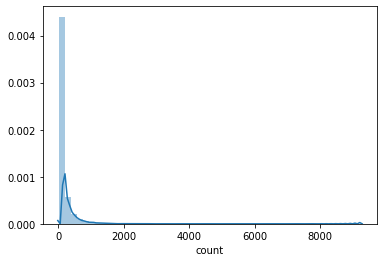

In [29]:
sns.distplot(user_stats['count'])

Skewed, but probably not as strongly as item rating count.  What are its numeric stats?

In [30]:
user_stats['count'].describe()

count    138493.000000
mean        144.413530
std         230.267257
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
Name: count, dtype: float64

The min is 20.  This is because MovieLens only published the rating profiles of users who have rated at least 20 movies.

> **Question to Ponder:** what does that mean about the generalizability of inferences from this data? Should we add something more to our list of biases at the top?

The mean is within the IQR, confirming that it is less strongly skewed than rating count.  It has a few, strong outliers.  Let's look at the 90th percentile - what is the size such that 90% of users have at most that many ratings?

In [31]:
user_stats['count'].quantile(0.9)

334.0

With distributions with a few outliers, it is sometimes useful to show a *truncated histogram* - lt's look at every user with at most 500 ratings:

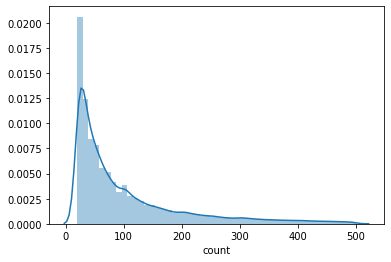

In [32]:
sns.distplot(user_stats.loc[user_stats['count'] <= 500, 'count'])